In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cd "drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [4]:
data = np.load("mnist_train_images.npy")
data.shape
data = (torch.Tensor(data)-127)/127

y = np.load("train_labels.npy")
y = y.astype(np.int64)
data_y = np.zeros((y.size, y.max()+1))
for cnt,i in enumerate(y):
  data_y[cnt][i] = 1

data_y = torch.Tensor(data_y)
print(y[:5])
data_y[:5]

[[5]
 [0]
 [4]
 [1]
 [9]]


tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [0]:
class Generator(torch.nn.Module):
  
  def __init__(self):
    super(Generator, self).__init__()
    
    self.fc1 = torch.nn.Linear(100, 128)
    self.fc1_ = torch.nn.Linear(10, 128)
    self.lrelu1 = torch.nn.LeakyReLU(0.3)
    self.fc2 = torch.nn.Linear(128, 256)
    self.lrelu2 = torch.nn.LeakyReLU(0.3)
    self.fc3 = torch.nn.Linear(256, 512)
    self.lrelu3 = torch.nn.LeakyReLU(0.3)
    self.fc4 = torch.nn.Linear(512, 784)
    self.tan = torch.nn.Tanh()

  def forward(self, x, y):

    out = self.fc1(x)
    y_out = self.fc1_(y)
    out = out + y_out
    out = self.lrelu1(out)
    out = self.fc2(out)
    out = self.lrelu2(out)
    out = self.fc3(out)
    out = self.lrelu3(out)
    out = self.fc4(out)
    out = self.tan(out)

    return out

In [0]:
class Discriminator(torch.nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.fc1 = torch.nn.Linear(784, 512)
    self.fc1_ = torch.nn.Linear(10, 512)
    self.lrelu1 = torch.nn.LeakyReLU(0.3)
    self.drp1 = torch.nn.Dropout(0.2)
    self.fc2 = torch.nn.Linear(512, 256)
    self.lrelu2 = torch.nn.LeakyReLU(0.3)
    self.drp2 = torch.nn.Dropout(0.2)
    self.fc3 = torch.nn.Linear(256, 128)
    self.lrelu3 = torch.nn.LeakyReLU(0.3)
    self.drp3 = torch.nn.Dropout(0.2)
    self.fc4 = torch.nn.Linear(128, 1)
    self.sig = torch.nn.Sigmoid()

  def forward(self, x, y):
    
    out = self.fc1(x)
    y_out = self.fc1_(y)
    out = out + y_out
    out = self.lrelu1(out)
    out = self.drp1(out)
    out = self.fc2(out)
    out = self.lrelu2(out)
    out = self.drp2(out)
    out = self.fc3(out)
    out = self.lrelu3(out)
    out = self.drp3(out)
    out = self.fc4(out)
    out = self.sig(out)

    return out

In [0]:
def gen_train(gen, disc, label_data, real_labels, batch_size=1, z_size=100):

  z = torch.randn(batch_size, z_size).to(device)
  gen_out = gen(z, label_data)
  disc_out = disc(gen_out, label_data)

  gen_optim.zero_grad()
  # error = torch.mean(torch.log(disc_out))
  loss = torch.nn.BCELoss()
  error = loss(disc_out, real_labels)
  error.backward()
  gen_optim.step()

  return error

In [0]:
def disc_train(gen, disc, real_data, label_data, real_labels, fake_labels, batch_size=1, z_size=100):
  
  z = torch.randn(batch_size, z_size).to(device)
  gen_out = gen(z, label_data)
  real_pred = disc(real_data, label_data)
  fake_pred = disc(gen_out, label_data)

  disc_optim.zero_grad()
  loss = torch.nn.BCELoss()
  error = loss(real_pred, real_labels) + loss(fake_pred, fake_labels)
  error.backward()
  # error = (torch.log(real_pred) + torch.log(1 - fake_pred)
  # (-error).backward()
  disc_optim.step()

  real_val = torch.mean(real_pred)
  fake_val = torch.mean(fake_pred)

  return error, real_val, fake_val

In [0]:
def train_gan(gen, disc, data, label_data, batch_size=1, z_size=100, k=1, epochs=10):

  real_labels = torch.ones(batch_size,1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)
  
  for epoch in range(epochs):
    for i in range(0, len(data), batch_size):
      real_data = data[i:i+batch_size].to(device)
      lbl_data = label_data[i:i+batch_size].to(device)

      for i in range(k):
        disc_loss, real_val, fake_val = disc_train(gen, disc, real_data, lbl_data, real_labels, fake_labels, batch_size, z_size)

      gen_loss = gen_train(gen, disc, lbl_data, real_labels, batch_size, z_size)

    if(epoch+1)%50 == 0 or epoch == 0:
      print("Epoch: ", epoch+1)
      print("Discriminator Loss: ", disc_loss.item())
      print("Real Mean: ", real_val.item())
      print("Fake Mean: ", fake_val.item())
      print("Generator Loss: ", gen_loss.item())

In [0]:
gen = Generator().to(device)
disc = Discriminator().to(device)
gen_optim = torch.optim.Adam(gen.parameters(), lr=0.0002)
disc_optim = torch.optim.Adam(disc.parameters(), lr=0.0002)

In [11]:
train_gan(gen, disc, data, data_y, batch_size=10000, k=1, epochs=3000)

Epoch:  1
Discriminator Loss:  1.0071152448654175
Real Mean:  0.7357397675514221
Fake Mean:  0.5030049681663513
Generator Loss:  0.6886070966720581
Epoch:  50
Discriminator Loss:  0.0291297547519207
Real Mean:  0.9839464426040649
Fake Mean:  0.01035989634692669
Generator Loss:  6.8008270263671875
Epoch:  100
Discriminator Loss:  0.08814506232738495
Real Mean:  0.9630162119865417
Fake Mean:  0.04251366853713989
Generator Loss:  4.834329605102539
Epoch:  150
Discriminator Loss:  0.09801629185676575
Real Mean:  0.9503599405288696
Fake Mean:  0.03946571424603462
Generator Loss:  5.277697563171387
Epoch:  200
Discriminator Loss:  1.594757080078125
Real Mean:  0.6030951142311096
Fake Mean:  0.5109609961509705
Generator Loss:  1.2068899869918823
Epoch:  250
Discriminator Loss:  0.32093000411987305
Real Mean:  0.8674598336219788
Fake Mean:  0.12650585174560547
Generator Loss:  3.4519639015197754
Epoch:  300
Discriminator Loss:  0.9730404615402222
Real Mean:  0.7483769059181213
Fake Mean:  0.33

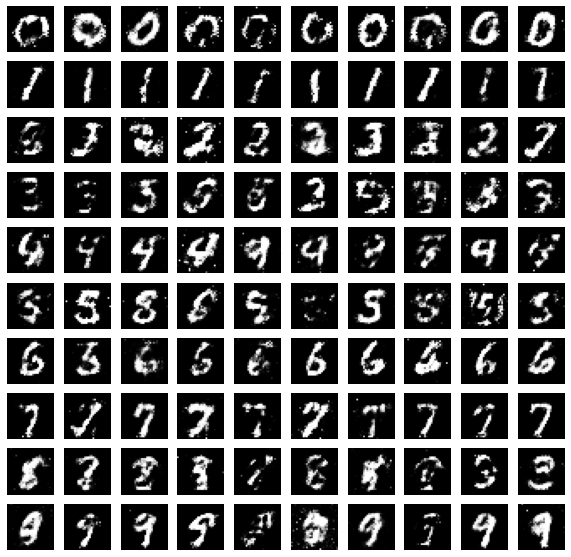

In [37]:
fig, ax = plt.subplots(figsize=(10,10), nrows=10, ncols=10)

plt.axis('off')
i=0
cnt = 0
for row in ax:
  for col in row:
    dummy = torch.randn(1,100).to(device)
    dummy_y = torch.zeros(10).to(device)
    dummy_y[cnt] = 1
    image = gen(dummy, dummy_y)
    image = image.view(28,28)
    col.imshow(image.detach().cpu().numpy(), cmap="gray")
    col.set_axis_off()
    i+=1
  cnt+=1

plt.show()